This file applies built-in MHA, no mask, non normalize Y

# HELPER FUNCTIONS

In [32]:
%run tf_helpers.py
import numpy as np
import pickle
import tensorflow as tf

def generate_xy(file_name, unique_set, test_set=None):
    with open(file_name, "rb") as file:
        stat = pickle.load(file)
        file.close()

    path_links = stat["data"]["paths_link"]
    demand = stat["data"]["demand"]
    path_flows = stat["path_flow"]
    nodes = stat["data"]["nodes"]
    net = stat["data"]["network"]

    # Get X
    Graph = get_graphMatrix(net, nodes)
    OD_demand = get_demandMatrix(demand, nodes)
    Path_tensor = get_pathMatrix(path_links, nodes, unique_set)
    Frequence = get_frequenceMatrix(path_links, net, nodes)

    X = np.concatenate((Graph, OD_demand, Path_tensor, Frequence), axis=1)
    X = normalize(X)
    X = tf.convert_to_tensor(X, dtype=tf.float32) # 625x8    
    
    # Get Y
    Flow = get_flowMatrix(demand, path_flows, nodes)
    Y = np.concatenate((Flow, OD_demand), axis=1)
    Y, scaler = normalizeY(Y)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)   
    
    if test_set:
        return X, Y, scaler
    return X, Y

# ATTENTION AND TRANSFORMER

In [33]:
import tensorflow as tf
from keras import layers as tfl
from keras import regularizers, Sequential
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization

class EncoderLayer(tfl.Layer):
    def __init__(self, input_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.attn_layer = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(input_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.dropout = tfl.Dropout(dropout)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=None):
        attn_output = self.attn_layer(query=x, key=x, value=x)
        x = self.layer_norm1(x + self.dropout(attn_output))
        x = self.layer_norm1(self.dropout(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm2(x + ffn_output)
        x = self.layer_norm2(self.dropout(x))
        return x

class Encoder(tfl.Layer):
    def __init__(self, input_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [EncoderLayer(input_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]
        self.dense = tfl.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return self.dense(output)

class DecoderLayer(tfl.Layer):
    def __init__(self, output_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.mha1 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        self.mha2 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(output_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.layer_norm3 = tfl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfl.Dropout(dropout)
        self.dropout2 = tfl.Dropout(dropout)
        self.dropout3 = tfl.Dropout(dropout)

    def call(self, x, encoder_output, training=None):
        attn1 = self.mha1(query=x, key=x, value=x, training=training)
        x = self.layer_norm1(x + self.dropout1(attn1))
        # x = self.layer_norm3(self.dropout3(x)) # ignore this layer, loss 0.0022 in 150 epochs

        attn2 = self.mha2(query=x, key=encoder_output, value=encoder_output, training=training)
        x = self.layer_norm2(x + self.dropout2(attn2))
        # x = self.layer_norm3(self.dropout3(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm3(x + ffn_output)
        x = self.layer_norm3(self.dropout3(x))
        return x

class Decoder(tfl.Layer):
    def __init__(self, output_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [DecoderLayer(output_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]

    def call(self, x, encoder_output, training=None):
        output = x
        for layer in self.layers:
            output = layer(output, encoder_output, training=training)
        return output

class Transformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model, E_layer, D_layer, heads, dropout, l2_reg):
        super().__init__()
        self.encoder = Encoder(input_dim, d_model, E_layer, heads, dropout, l2_reg)
        self.decoder = Decoder(output_dim, d_model, D_layer, heads, dropout, l2_reg)
        self.activation = Activation('sigmoid')

    def call(self, x, y, training=None):
        encoder_output = self.encoder(x, training=training)
        decoder_output = self.decoder(y, encoder_output, training=training)
        decoder_output = self.activation(decoder_output)
        return decoder_output

    def eval(self):
        for layer in self.encoder.layers:
            layer.trainable = False
        for layer in self.decoder.layers:
            layer.trainable = False

    def train(self):
        for layer in self.encoder.layers:
            layer.trainable = True
        for layer in self.decoder.layers:
            layer.trainable = True

    def fit(self, train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device):
        # Define the early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.0001,
            verbose=1
        )

        train_losses = []
        val_losses = []

        src, trg = next(iter(train_data_loader))
        self(src, trg, training=True)

        self.compile(optimizer=optimizer, loss=loss_fn)

        with tqdm(total=epochs, unit="epoch") as pbar:
            for epoch in range(epochs):
                # Training phase
                self.train()
                total_train_loss = 0
                for src, trg in train_data_loader:
                    with tf.device(device):
                        with tf.GradientTape() as tape:
                            output = self.call(src, trg)
                            loss = loss_fn(trg, output)

                        # Backpropagate and update the model
                        gradients = tape.gradient(loss, self.trainable_variables)
                        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                        total_train_loss += loss.numpy()
                        pbar.set_description(f"Train Loss: {total_train_loss / len(train_data_loader):.4f}")

                # Validation phase
                self.eval()
                total_val_loss = 0
                for src, trg in val_data_loader:
                    with tf.device(device):
                        output = self.call(src, trg)
                        loss = loss_fn(trg, output)
                        total_val_loss += loss.numpy()

                        pbar.set_description(f"Val Loss: {total_val_loss / len(val_data_loader):.4f}")

                pbar.update(1)
                train_losses.append(total_train_loss / len(train_data_loader))
                val_losses.append(total_val_loss / len(val_data_loader))
                print(f"Epoch: {epoch+1} - Train Loss: {total_train_loss/len(train_data_loader):.4f}, Val Loss: {total_val_loss/len(val_data_loader):.4f}")

                # Check for early stopping
                if early_stopping.model is not None:
                    early_stopping.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    reduce_lr.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    if early_stopping.stopped_epoch > 0:
                        print(f"Early stopping triggered at epoch {early_stopping.stopped_epoch + 1}")
                        break
        return self, train_losses, val_losses
    
    def predict(self, x, src_mask, tgt_mask):
        # Get the encoder output
        encoder_output = self.encoder(x, src_mask, training=False)
        # Initialize the decoder input with zeros (same shape as the expected output)
        decoder_input = tf.zeros((tf.shape(x)[0], tf.shape(x)[1], 3))
        # Generate predictions in one go
        predictions = self.decoder(decoder_input, encoder_output, src_mask, tgt_mask, training=False)
        predictions = self.activation(predictions)

        tgt_mask = tf.cast(tgt_mask, dtype=predictions.dtype)
        predictions = predictions * tgt_mask
        return predictions

# PARAMETERS

In [34]:
DATA_SIZE = 1000
FOLDERS = [f'Solution/Output{i+1}' for i in range(4)]
TRAIN_RATE = 0.7
VAL_RATE = 0.2
TEST_RATE = 0.1
BATCH_SIZE = 64

# TRAINING 
device = 'gpu'
input_dim = 8
output_dim = 3
d_model = 128
heads=8
E_layer = 8
D_layer = 3
epochs = 150
learning_rate = 0.001
dropout=0.5
l2_reg=1e-6

# CREATE DATASET

In [35]:
files = load_files_from_folders(FOLDERS, max_files=50)
path_set_dict = path_encoder(files)
print("Path set number: ", len(path_set_dict))

class Dataset:
    def __init__(self, files):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []

        for file_name in tqdm(files):
            x, y = generate_xy(file_name, path_set_dict)
            self.X.append(x)
            self.Y.append(y)

        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(files):
    X = []
    Y = []
    Scalers = []
    for file_name in tqdm(files) :
        x, y, scaler = generate_xy(file_name, path_set_dict, test_set=True)
        X.append(x)
        Y.append(y)
        Scalers.append(scaler)

    X = tf.stack(X, axis=0)
    Y = tf.stack(Y, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset, Scalers

Path set number:  6268


In [36]:
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
train_files, val_files, test_files = split_dataset(files, TRAIN_RATE, VAL_RATE)

train_dataset = Dataset(train_files)
train_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

val_dataset = Dataset(val_files)
val_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

# test_dataset = Dataset(test_files)
# test_data_loader = test_dataset.to_tf_dataset(BATCH_SIZE)
test_dataset, scalers = get_test_set(test_files)

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

# TRAIN MODEL

In [37]:
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.losses import MeanSquaredError
import time

model = Transformer(input_dim=input_dim, output_dim=output_dim,
                    d_model=d_model, E_layer=E_layer, D_layer=D_layer,
                    heads=heads, dropout=dropout, l2_reg=l2_reg)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0, decay=l2_reg)

start = time.time()
model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

  0%|          | 0/150 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.2382, Val Loss: 0.2306
Epoch: 2 - Train Loss: 0.2240, Val Loss: 0.2173
Epoch: 3 - Train Loss: 0.2110, Val Loss: 0.2044
Epoch: 4 - Train Loss: 0.1983, Val Loss: 0.1919
Epoch: 5 - Train Loss: 0.1860, Val Loss: 0.1799
Epoch: 6 - Train Loss: 0.1742, Val Loss: 0.1684
Epoch: 7 - Train Loss: 0.1630, Val Loss: 0.1574
Epoch: 8 - Train Loss: 0.1523, Val Loss: 0.1470
Epoch: 9 - Train Loss: 0.1423, Val Loss: 0.1374
Epoch: 10 - Train Loss: 0.1329, Val Loss: 0.1284
Epoch: 11 - Train Loss: 0.1243, Val Loss: 0.1201
Epoch: 12 - Train Loss: 0.1163, Val Loss: 0.1125
Epoch: 13 - Train Loss: 0.1092, Val Loss: 0.1057
Epoch: 14 - Train Loss: 0.1027, Val Loss: 0.0996
Epoch: 15 - Train Loss: 0.0969, Val Loss: 0.0941
Epoch: 16 - Train Loss: 0.0917, Val Loss: 0.0892
Epoch: 17 - Train Loss: 0.0871, Val Loss: 0.0850
Epoch: 18 - Train Loss: 0.0830, Val Loss: 0.0811
Epoch: 19 - Train Loss: 0.0794, Val Loss: 0.0777
Epoch: 20 - Train Loss: 0.0762, Val Loss: 0.0747
Epoch: 21 - Train Loss: 0.073

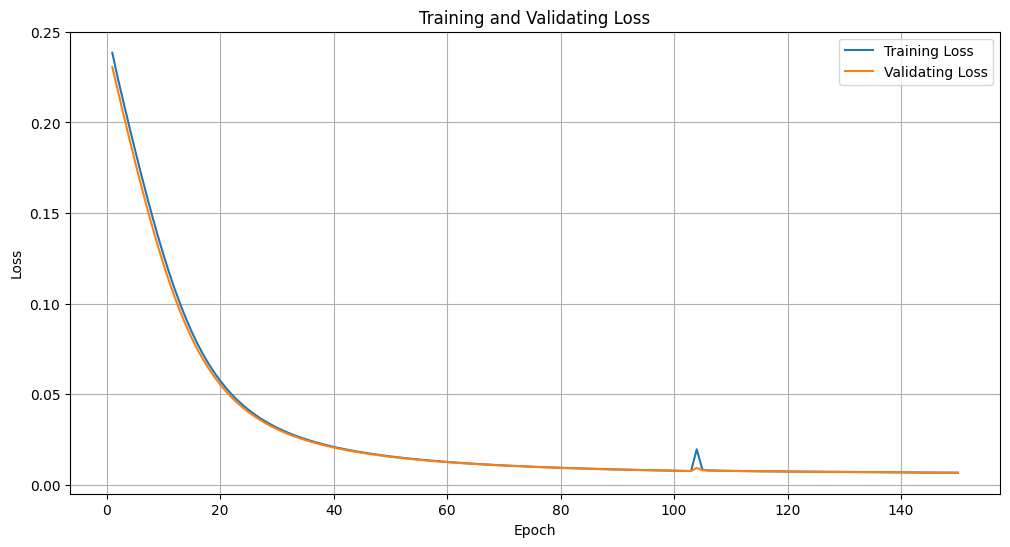

In [27]:
plot_loss(train_loss, val_loss, epochs)

# CHECK DELAY OF PREDICTED VALUES

In [28]:
def inversed(normed, scaler):
    # normed: 625x3
    tensor = scaler.inverse_transform(np.transpose(normed))
    tensor = np.transpose(tensor)
    return tensor


def predict_withScaler(model, test_data_loader, scalers, device):
    model.eval()
    predicted_values = []
    scaler_idx = 0
    for src, trg in test_data_loader:
        with tf.device(device):
            # output = model.predict(src)
            output = model.call(src, trg)
            for i in range(len(src)):
                scaler = scalers[scaler_idx]
                scaler_idx +=1
                pred_matrix = inversed(output[i].numpy(), scaler)
                predicted_values.append(pred_matrix)

    return predicted_values

pred_tensor = predict_withScaler(model, test_dataset, scalers, device)

In [ ]:
%run tf_helpers.py

file_name = test_files[0]
stat = read_file(file_name)
# dict = extract_flow(pred_tensor[0][0])
pred_df, _, _, _ = create_pred_df(pred_tensor[0], stat)
pred_link_flow = sum_pred_link_flow(pred_df, stat)

pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)
UE_link, path_link_df, avg_path_cost = mean_path_cost(stat)
pred_df

In [29]:
import numpy as np
%run tf_helpers.py

size = 400

Avg_delay, Solution_avg_delay, Len_origin, Len_pred, Nan_num, Avg_path_cost = [], [], [], [], [], []
for i, filename in tqdm(zip(pred_tensor[:size], test_files[:size]), total=size):
    avg_delay, solution_avg_delay, len_origin, len_pred, nan_num, avg_path_cost = single_avg_delay(i, filename)
    Avg_delay.append(avg_delay)
    Solution_avg_delay.append(solution_avg_delay)
    Len_origin.append(len_origin)
    Len_pred.append(len_pred)
    Nan_num.append(nan_num)
    Avg_path_cost.append(avg_path_cost)

df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'Pred_ad': Avg_delay,
    'Solution_ad': Solution_avg_delay
})
df.to_csv("predicted_result.csv")
p = np.mean(Avg_delay)
s = np.mean(Solution_avg_delay)
print("Avg path cost: ", round(np.mean(Avg_path_cost), 4), "mins")
print("Prediction average delay: ", round(p,4), "mins")
print("Solution average delay: ", round(s, 4), "mins")
print(f"Difference: {round(p-s,4)} mins")

  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  123.7477 mins
Prediction average delay:  17.0489 mins
Solution average delay:  0.0176 mins
Difference: 17.0314 mins


In [12]:
# Data random generate capacity, length, fft for full scenario, then remove 5, 10, 15 links
# Add frequency to input 
# ignore 1st layer norm(dropout) in decoder layer

# device = 'gpu'
# input_dim = 8
# output_dim = 3
# d_model = 128
# heads=8
# E_layer = 8
# D_layer = 3
# epochs = 150
# learning_rate = 0.001
# dropout=0.5
# l2_reg=1e-6
# Epoch: 150 - Train Loss: 0.0022, Val Loss: 0.0022

  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  3.529 mins
Prediction average delay:  0.1828 mins
Solution average delay:  0.0026 mins
Difference: 0.1802 mins


Data random generate capacity, length, fft for full scenario, then remove 5, 10, 15 links
Add frequency to input 
ignore 1st layer norm(dropout) in decoder layer

device = 'gpu'
input_dim = 8
output_dim = 3
d_model = 128
heads=8
E_layer = 8
D_layer = 3
epochs = 150
learning_rate = 0.001
dropout=0.5
l2_reg=1e-6
Epoch: 150 - Train Loss: 0.0022, Val Loss: 0.0022

Avg path cost:  3.529 mins
Prediction average delay:  0.1828 mins
Solution average delay:  0.0026 mins
Difference: 0.1802 mins

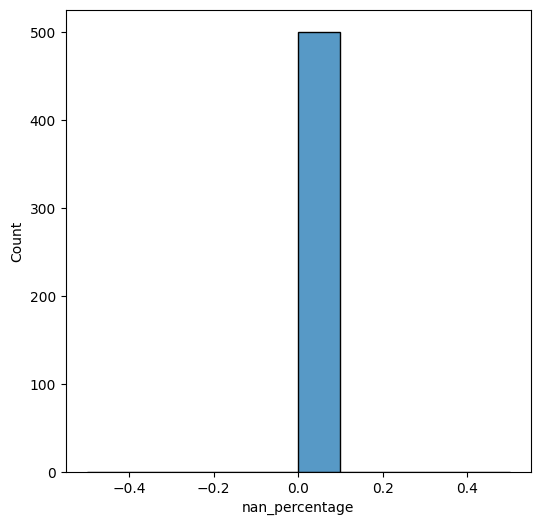

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(6,6))
sns.histplot(df['nan_percentage'], bins=10)
plt.show()